In [147]:
import matplotlib.pyplot as plt

In [148]:
import numpy as np
import pandas as pd
import datetime
import pytz
import os

In [30]:
def convert_datetime_timezone(dt, tz1, tz2):
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)

    dt = datetime.datetime.strptime(dt,"%Y-%m-%d %H.%M.%S")
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    dt = dt.strftime("%Y-%m-%d %H:%M:%S")

    return dt

In [133]:
def get_time_interval(ts, telas):
    time_interval = []
    for i in range(len(ts)):
        t1 = datetime.datetime.strptime(ts[i],"%Y-%m-%d %H:%M:%S")
        tela = datetime.timedelta(seconds=telas[i])
        t2 = t1 + tela
        t2 = t2.strftime("%Y-%m-%d %H:%M:%S")
        time_interval.append([ts[i], t2])
    return time_interval

In [317]:
#path = "/global/cscratch1/sd/yuanlai/gf_test/read_test_results/vary_cc_result/06.28-20.25.52_night_posix.txt"
path = "/global/cscratch1/sd/yuanlai/gf_test/l2g_test_results/vary_cc_result/07.04-19.52.08_mpi.txt"

In [318]:
ccMax = 96
totalSize = 2**40
ccList = range(1, ccMax + 1)

In [319]:
tr = []
timeElapsed = []
timeStamps = []
with open(path, 'r') as fp:
        for cc in range(1, ccMax + 1):
                timestamp = fp.readline().rstrip('\n')
                if int(timestamp.split('.')[0]) >= 19:
                    timestamp = '2018-7-4 ' + timestamp
                else:
                    timestamp = '2018-7-5 ' + timestamp
                timeStamps.append(timestamp)
                timestr = fp.readline().rstrip('\n')
                #print timestr
                try:
                        time = float(timestr)
                except:
                        break
                timeElapsed.append(time)
                speed = totalSize / time
                speed = float("%.2f" % (speed / (2**30)))
                tr.append(speed)
                #print("cc=" + str(cc) + ":      " + "transfer rate=" + str(speed) + "GB/s")

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/yuanlai/gf_test/l2g_test_results/vary_cc_result/07.06-11.25.52_mpi.txt'

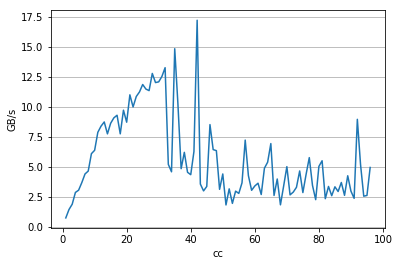

Highest transfer rate achieved is 17.22GB/s, when cc is 42


In [109]:
plt.plot(ccList, tr)
plt.xlabel("cc")
plt.ylabel("GB/s")
ax = plt.axes()        
ax.yaxis.grid()
plt.show()
trMax = max(tr)
trMaxIdx = tr.index(trMax) + 1
print("Highest transfer rate achieved is " + str(max(tr)) + "GB/s, when cc is " + str(trMaxIdx))

In [149]:
timeElapsed[95]

206.62

In [37]:
timeStampsUTC = [convert_datetime_timezone(timeStamp, 'America/Los_Angeles', 'UTC') for timeStamp in timeStamps]

In [123]:
type(timeStampsUTC[0])

str

In [134]:
time_interval = get_time_interval(timeStampsUTC, timeElapsed)

In [137]:
time_interval[:4]

[['2018-07-05 02:52:13', '2018-07-05 03:14:37'],
 ['2018-07-05 03:14:37', '2018-07-05 03:26:15'],
 ['2018-07-05 03:26:16', '2018-07-05 03:35:15'],
 ['2018-07-05 03:35:15', '2018-07-05 03:41:10']]

In [101]:
cpu_usage_path = "/global/cscratch1/sd/yuanlai/gf_test/dtn_cpu_usage/"
headers = ('cpu_usr', 'cpu_sys', 'cpu_idle', 'cpu_wait', 'cpu_hiq', 'cpu_siq', 'drd', 'dwr', \
               'net_recv', 'net_send', 'page_in', 'page_out', 'intr', 'csw', 'timestamp')

In [102]:
files = os.listdir(cpu_usage_path)
files.sort()
files

['dtn01.csv',
 'dtn02.csv',
 'dtn04.csv',
 'dtn05.csv',
 'dtn06.csv',
 'dtn07.csv',
 'dtn08.csv',
 'dtn09.csv',
 'dtn10.csv']

In [103]:
def load_nersc_data(fns):
    _ret = {}
    dtn_list = []
    for fn in fns:
        fn = path + fn
        dtn = fn.split('/')[-1][:5]
        dtn_list.append(dtn)
        _df = pd.read_csv(fn, skiprows=7, names=headers, header=None)
        _df['timestamp'] = _df.timestamp.apply(pd.datetime.utcfromtimestamp)
        _df.index = _df['timestamp']
        del _df['timestamp']
        _ret[dtn] = _df
    return _ret, dtn_list

In [104]:
dtn_data, dtn_list = load_nersc_data(files)

In [159]:
len(time_interval)

96

In [232]:
all_dtn_all_cc = []
for i in range(ccMax):
    all_dtn=[]
    for dtn in dtn_list[:(i+1)]:
        all_dtn_one_idle = list(dtn_data[dtn][time_interval[i][0]:time_interval[i][1]]['cpu_idle'])
        all_dtn_one_usage = [100 - one_idle for one_idle in all_dtn_one_idle]
        all_dtn.append(all_dtn_one_usage)
    minLen = min((len(x) for x in all_dtn))
    all_dtn_trim = [one_dtn[:minLen] for one_dtn in all_dtn]
    all_dtn_array = np.array(all_dtn_trim)
    all_dtn_avg = list(np.average(all_dtn_array, axis=0))
    all_dtn_all_cc.append(all_dtn_avg)

In [237]:
len(all_dtn_all_cc)

96

In [315]:
plt.figure(figsize=(20, 5))
fig, ax1 = plt.subplots()
boxprops = dict(linewidth=3, color='black')
medianprops = dict(linestyle='-', linewidth=3, color='darkgoldenrod')
capprops = dict(linewidth=2, color='black')
whiskerprops = dict(linewidth=2, color='black')
bplot = ax1.boxplot(all_dtn_all_cc, widths=0.5, boxprops=boxprops, \
                    medianprops=medianprops, capprops=capprops, whiskerprops=whiskerprops, \
                    patch_artist=True, notch=True, showfliers=False)

ax1.set_xlabel("cc")
ax1.set_ylabel("CPU Average Usage(%)")

ax2 = ax1.twinx()
ax2.plot(tr)
ax2.set_ylabel("Transfer Speed(GB/s)")

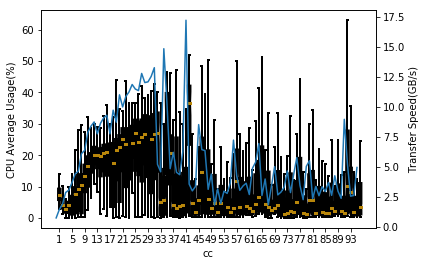

In [316]:
ax1.set_xticks(np.arange(min(ccList), max(ccList)+1, 4.0))
ax1.set_xticklabels(ccList[::4])
#plt.savefig("l2g_speed_cpu.pdf")
plt.show()


In [291]:
np.arange(min(ccList), max(ccList)+1, 4.0)

array([  1.,   5.,   9.,  13.,  17.,  21.,  25.,  29.,  33.,  37.,  41.,
        45.,  49.,  53.,  57.,  61.,  65.,  69.,  73.,  77.,  81.,  85.,
        89.,  93.])